# Q learning based solution for [FrozenLake-v0](https://gym.openai.com/envs/FrozenLake-v0)

Mostly based on explanations in [mnemstudio tutorial](http://mnemstudio.org/path-finding-q-learning-tutorial.htm) and this wonderful RL series in [Medium](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0).

### With a simple neural net using tensorflow

In [259]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Load Open AI gym


In [260]:
env = gym.make('FrozenLake-v0')

[2017-05-27 17:32:21,824] Making new env: FrozenLake-v0


In [261]:
# Load Gym parameters
state_size = env.observation_space.n
action_size = env.action_space.n

In [269]:
gamma_reduction = 0.99
num_episodes = 10000

learning_rate = 0.01

# print the reward for episode every n episodes
print_every = 1000

max_loops_per_episode = state_size * action_size * 2

In [271]:
# Setup Tensors
tf.reset_default_graph()

# hidden_layer_size = 10
# W1Size = [state_size, hidden_layer_size]
# W2Size = [hidden_layer_size, action_size]

# bais1 = tf.Variable(tf.random_normal([hidden_layer_size]))
# bias2 = tf.Variable(tf.random_normal([action_size]))

# Win = tf.Variable(tf.random_uniform(W1Size, 0, 0.01))
# WOut = tf.Variable(tf.random_uniform(W2Size, 0, 0.01))

# layer1 = tf.add(tf.matmul(inputs, Win), bais1)
# Qout = tf.add(tf.matmul(layer1, WOut), bias2)

inputs = tf.placeholder(shape=[1,state_size],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([state_size,action_size],0,0.01))
# bias2 = tf.Variable(tf.random_normal([action_size]))
Qout = tf.matmul(inputs,W)
predicted_move = tf.argmax(Qout,1)


nextQ = tf.placeholder(shape=[1,action_size],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
updateModel = trainer.minimize(loss)

In [272]:
def play(print_every, max_loops_per_episode):
    
    rand_action_prob = 0.1
    init = tf.global_variables_initializer()
    
    # Training logic
    rewards = []
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_episodes):
            # Get the starting state
            state = env.reset()
            done = False
            episode_reward = 0
            # Algorithm works by taking a step at a time based on Q learning. Gym tells us at each step if we reached `done`
            # state. Done state means either we failed or reach goal state. But it could be possible that our algorithm
            # keeps going in circles and never reaches done state. We should break this.
            # In my approach I assume that if our step count is twice size of the board that means we are not getting anywhere.
            count = 0
            while count < max_loops_per_episode and not done:
                count += 1
                next_action, predictedQ = sess.run([predicted_move,Qout], feed_dict={inputs:np.identity(16)[state:state+1]})
                
                    # According to the specifications we have to take into account random wind which might force us into a
    # arbitrary action
                if np.random.rand(1) < rand_action_prob:
                    next_action[0] = env.action_space.sample()
                
                # Get new state and reward by taking the `predicted_move`
                new_state, reward, done, _ = env.step(next_action[0])

                # Get Q values for next state
                nextStateQ = sess.run(Qout, feed_dict={inputs:np.identity(16)[new_state:new_state+1]})
                maxNextState = np.max(nextStateQ)
                updatedQ = predictedQ
                updatedQ[0, next_action[0]] = reward + gamma_reduction * maxNextState
                _, _ = sess.run([updateModel, W] ,feed_dict={inputs:np.identity(16)[state:state+1],nextQ:updatedQ})
                
                episode_reward += reward
                state = new_state
                
                if done == True:
                    #Reduce chance of random action because of wind as we train the model.
                    rand_action_prob = 1./((i/50) + 10)
                    break                
                
            rewards.append(episode_reward)
            if i % print_every == 0:
                print "Episode: {}, Total Reward: {}".format(i, str(sum(rewards)/(i+1)))
        
        print "================== Reward ================"
        print "Total Reward : "+ str(sum(rewards)/num_episodes)
        
        return rewards

            

In [273]:
rewards = play(print_every, max_loops_per_episode)

Episode: 0, Total Reward: 1.0
Episode: 1000, Total Reward: 0.0769230769231
Episode: 2000, Total Reward: 0.0764617691154
Episode: 3000, Total Reward: 0.0779740086638
Episode: 4000, Total Reward: 0.0817295676081
Episode: 5000, Total Reward: 0.0817836432713
Episode: 6000, Total Reward: 0.0849858356941
Episode: 7000, Total Reward: 0.0879874303671
Episode: 8000, Total Reward: 0.0951131108611
Episode: 9000, Total Reward: 0.101322075325
================== Reward ================
Total Reward : 0.1059


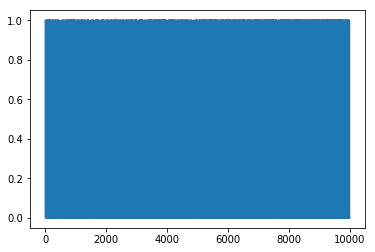

In [274]:
plt.plot(rewards)


In [275]:
print sum(rewards)

1059.0
